In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d jehanbhathena/weather-dataset


Dataset URL: https://www.kaggle.com/datasets/jehanbhathena/weather-dataset
License(s): CC0-1.0
 99% 583M/587M [00:35<00:00, 18.4MB/s]
100% 587M/587M [00:35<00:00, 17.3MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/weather-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/weather-dataset.zip' mode='r'>>

In [ ]:
import os
import pandas as pd

In [ ]:
data_dir = 'dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
df

filepaths     labels
0     dataset/sandstorm/3303.jpg  sandstorm
1     dataset/sandstorm/3577.jpg  sandstorm
2     dataset/sandstorm/3288.jpg  sandstorm
3     dataset/sandstorm/3471.jpg  sandstorm
4     dataset/sandstorm/3156.jpg  sandstorm
...                          ...        ...
6857       dataset/hail/0266.jpg       hail
6858       dataset/hail/0583.jpg       hail
6859       dataset/hail/0095.jpg       hail
6860       dataset/hail/0120.jpg       hail
6861       dataset/hail/0241.jpg       hail

[6862 rows x 2 columns]

In [ ]:
df.shape

(6862, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6862 entries, 0 to 6861
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  6862 non-null   object
 1   labels     6862 non-null   object
dtypes: object(2)
memory usage: 107.3+ KB


In [45]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
train_df,dummy_df = train_test_split(df, train_size= 0.8, shuffle=True, random_state= 123)

In [ ]:
valid_df , test_df = train_test_split(dummy_df, train_size= 0.6, shuffle=True, random_state= 123)

In [ ]:
batch_size=32
img_size=(256,256)
channels=3
img_shape = (img_size[0], img_size[1], channels)

def scalar(img):
  return img

tr_gen= ImageDataGenerator(preprocessing_function= scalar)
ts_gen= ImageDataGenerator(preprocessing_function= scalar)

train_gen=tr_gen.flow_from_dataframe(train_df , x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen=ts_gen.flow_from_dataframe(valid_df , x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=ts_gen.flow_from_dataframe(test_df , x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)




Found 5489 validated image filenames belonging to 11 classes.
Found 823 validated image filenames belonging to 11 classes.
Found 550 validated image filenames belonging to 11 classes.


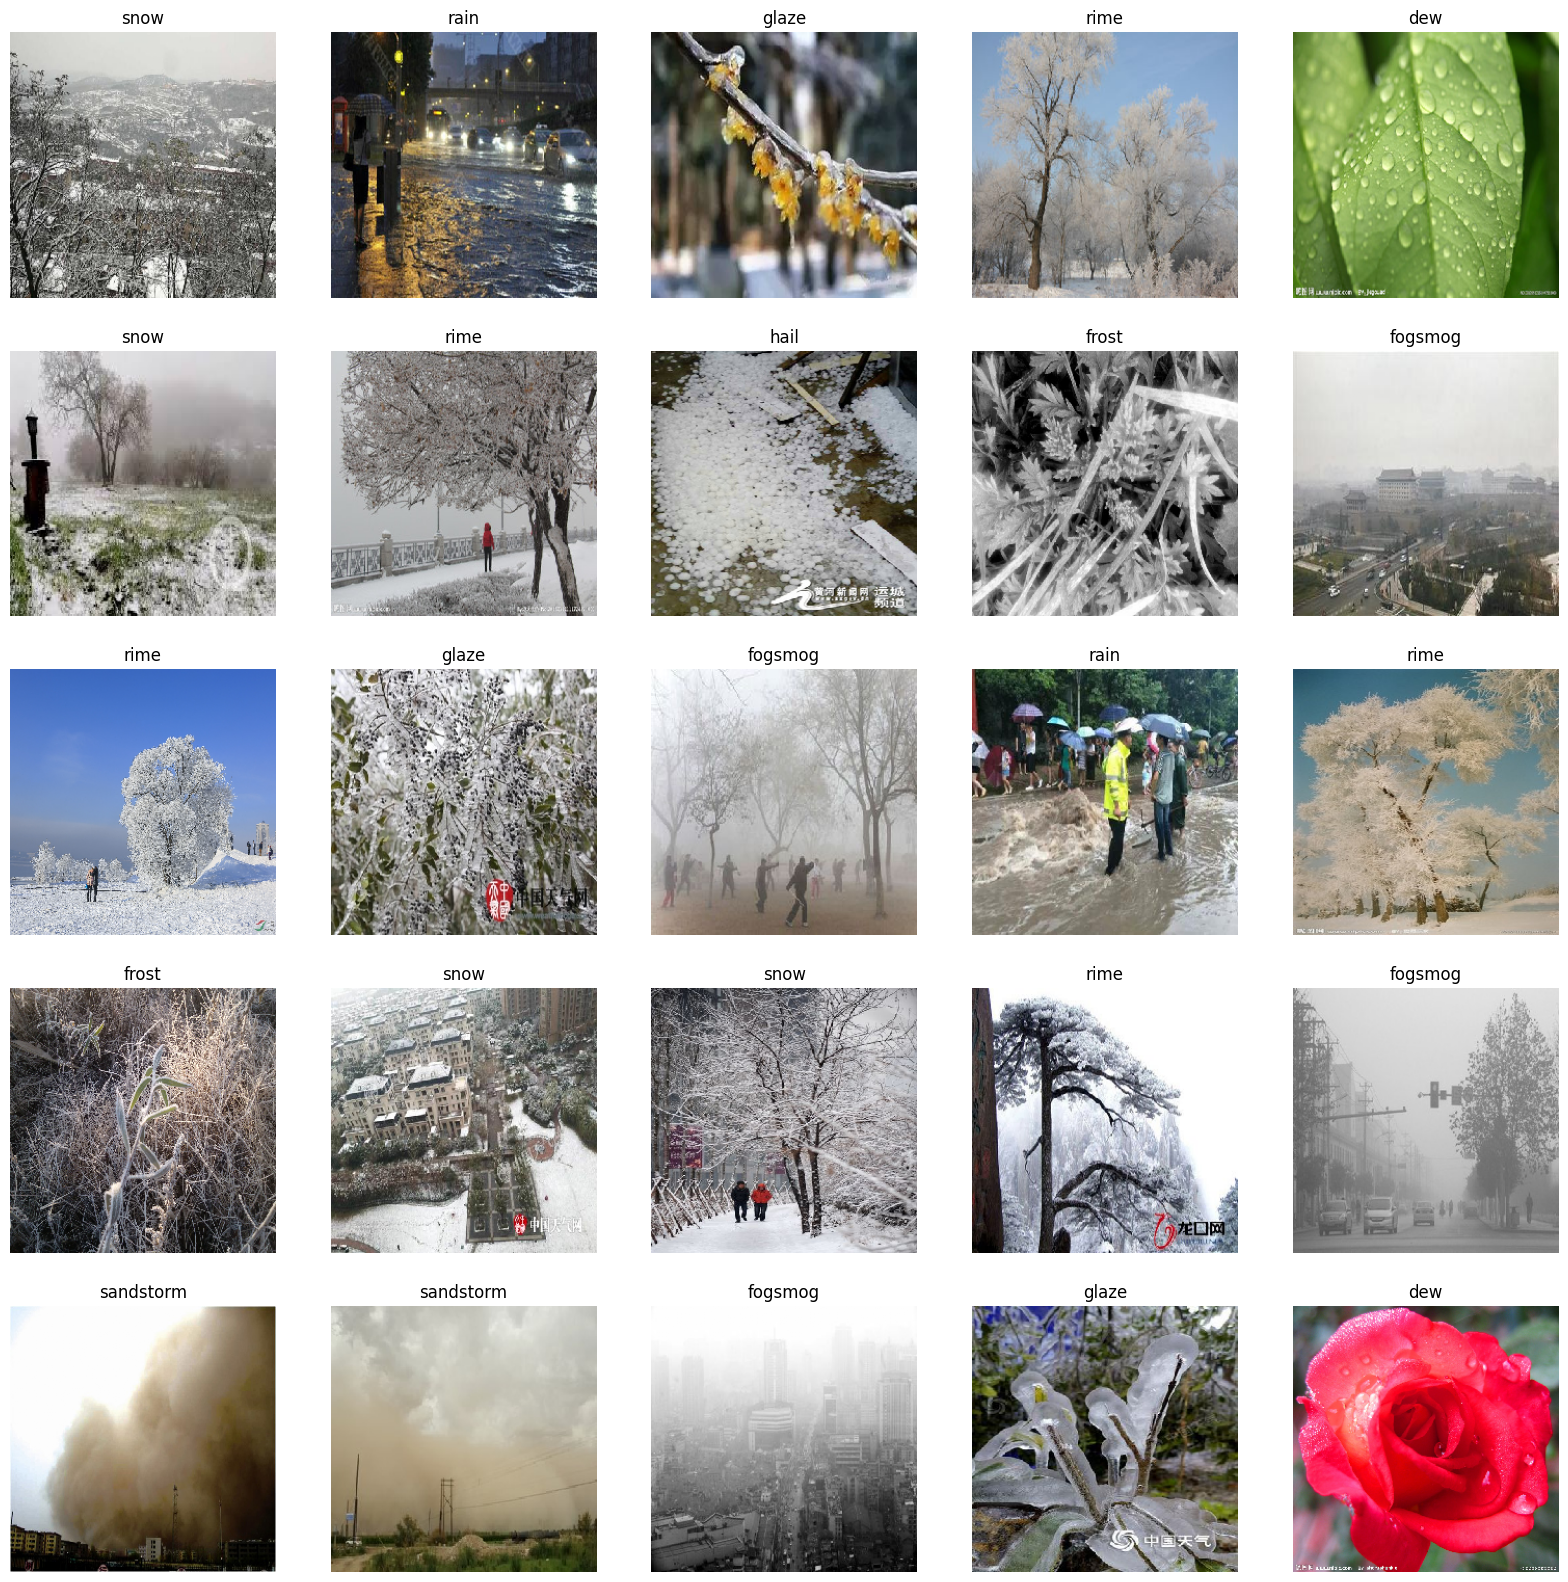

In [ ]:
g_dic=train_gen.class_indices
classes=list(g_dic.keys())

images, labels = next(train_gen)

length =len(labels)
sample = min(length,25)

plt.figure(figsize=(20,20))
for i in range(sample):
  plt.subplot(5,5,i+1)
  image = images[i]/255.0
  plt.imshow(image)
  plt.title(classes[np.argmax(labels[i])],color='black')
  plt.axis('off')
  #plt.tight_layout()
plt.show()

In [40]:
img_size=(256,256)
channels =3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model= tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

model= Sequential([base_model,
                   BatchNormalization(axis=-1, momentum =0.99, epsilon =0.001),
                   Dense(256,kernel_regularizer = regularizers.l2(l=0.016),activity_regularizer=regularizers.l1(0.006),bias_regularizer = regularizers.l1(0.006), activation ='relu'),
                   Dropout(rate=0.45, seed=123),
                   Dense(class_count, activation='softmax')])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization_2 (Bat  (None, 1536)              6144      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 11)                2827      
                                                                 
Total params: 11185978 (42.67 MB)
Trainable params: 1109

In [41]:
epoch=21
history = model.fit(train_gen, epochs=epoch, verbose=1, validation_data=valid_gen, validation_steps=None, shuffle=False)

Epoch 1/21
172/172 [==============================] - 186s 709ms/step - loss: 9.0783 - accuracy: 0.5240 - val_loss: 7.8006 - val_accuracy: 0.8262
Epoch 2/21
172/172 [==============================] - 115s 671ms/step - loss: 7.3652 - accuracy: 0.8167 - val_loss: 6.8482 - val_accuracy: 0.8809
Epoch 3/21
172/172 [==============================] - 115s 668ms/step - loss: 6.3331 - accuracy: 0.8809 - val_loss: 5.9327 - val_accuracy: 0.8931
Epoch 4/21
172/172 [==============================] - 115s 668ms/step - loss: 5.4108 - accuracy: 0.9222 - val_loss: 5.0561 - val_accuracy: 0.9089
Epoch 5/21
172/172 [==============================] - 115s 669ms/step - loss: 4.5972 - accuracy: 0.9393 - val_loss: 4.2913 - val_accuracy: 0.9089
Epoch 6/21
172/172 [==============================] - 115s 667ms/step - loss: 3.8706 - accuracy: 0.9555 - val_loss: 3.6289 - val_accuracy: 0.9162
Epoch 7/21
172/172 [==============================] - 115s 667ms/step - loss: 3.2232 - accuracy: 0.9687 - val_loss: 3.0430 -

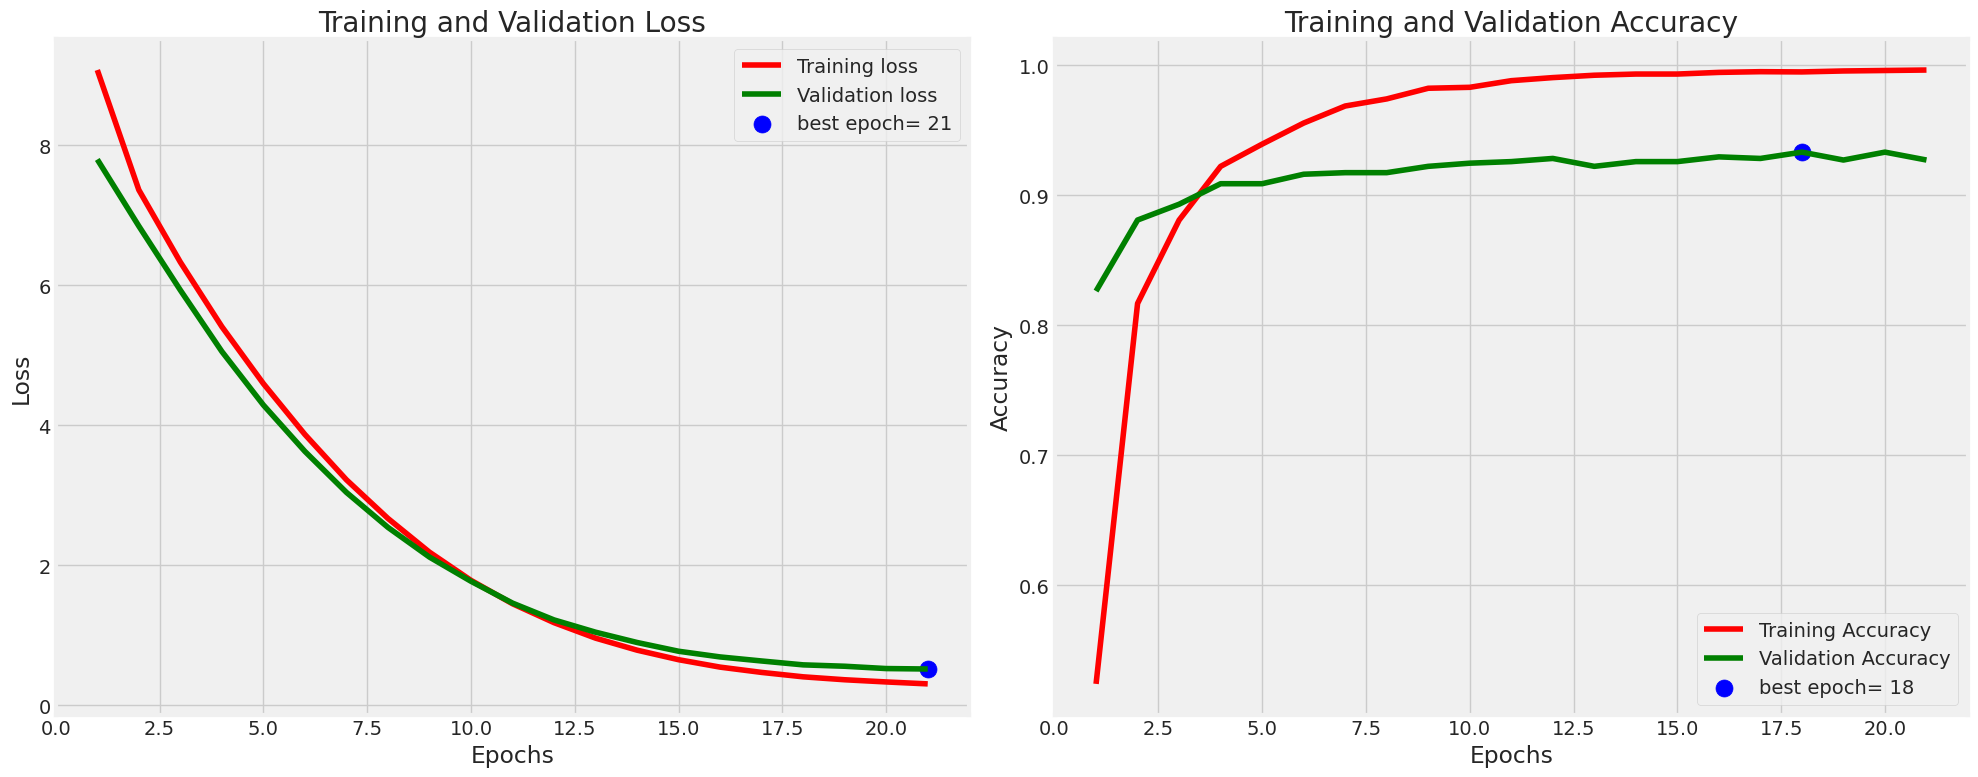

In [42]:
train_acc=history.history['accuracy']
train_loss= history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']

index_loss=np.argmin(val_loss)
val_lowest=val_loss[index_loss]
index_acc=np.argmax(val_acc)
acc_highest=val_acc[index_acc]

Epochs=[i+1 for i in range(len(train_acc))]
loss_label= f'best epoch= {str(index_loss + 1)}'
acc_label= f'best epoch= {str(index_acc + 1)}'


plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [43]:
train_score= model.evaluate(train_gen)
valid_score= model.evaluate(valid_gen)
test_score= model.evaluate(test_gen)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

18/18 [==============================] - 4s 215ms/step - loss: 0.4845 - accuracy: 0.9364
Train Loss:  0.2558706998825073
Train Accuracy:  0.9998177886009216
--------------------
Validation Loss:  0.5195671319961548
Validation Accuracy:  0.9270960092544556
--------------------
Test Loss:  0.48454755544662476
Test Accuracy:  0.9363636374473572


In [44]:
pred=model.predict_generator(test_gen)
y_pred=np.argmax(pred,axis=1)

<ipython-input-44-d2cab74b0061>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=model.predict_generator(test_gen)


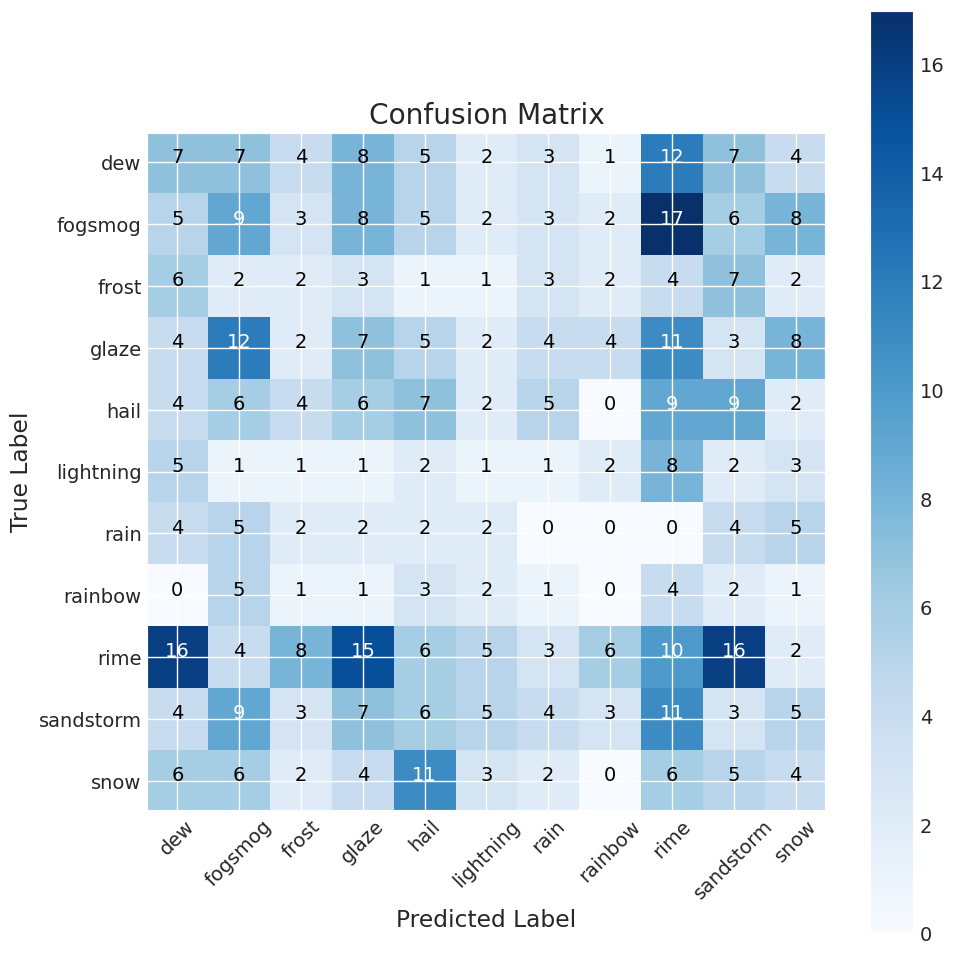

In [46]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [48]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))
print(confusion_matrix(test_gen.classes, y_pred))

              precision    recall  f1-score   support

         dew       0.11      0.12      0.12        60
     fogsmog       0.14      0.13      0.13        68
       frost       0.06      0.06      0.06        33
       glaze       0.11      0.11      0.11        62
        hail       0.13      0.13      0.13        54
   lightning       0.04      0.04      0.04        27
        rain       0.00      0.00      0.00        26
     rainbow       0.00      0.00      0.00        20
        rime       0.11      0.11      0.11        91
   sandstorm       0.05      0.05      0.05        60
        snow       0.09      0.08      0.09        49

    accuracy                           0.09       550
   macro avg       0.08      0.08      0.08       550
weighted avg       0.09      0.09      0.09       550

[[ 7  7  4  8  5  2  3  1 12  7  4]
 [ 5  9  3  8  5  2  3  2 17  6  8]
 [ 6  2  2  3  1  1  3  2  4  7  2]
 [ 4 12  2  7  5  2  4  4 11  3  8]
 [ 4  6  4  6  7  2  5  0  9  9  2]
 [ 5  1

In [49]:
model.save('Weathermodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
